In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import os

# If your model definitions (EncoderCNN, DecoderRNN) are in model.py,
# you can import them like this:
from model import EncoderCNN, DecoderRNN




In [7]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Hyperparameters (must match training)
embed_size = 256
hidden_size = 512
attention_dim = 256

# Paths to your checkpoints & vocab
encoder_ckpt = "C:/Users/soumy/Downloads/Image captioning using visual attention/models/encoder-10.ckpt"  # or your custom file
decoder_ckpt = "C:/Users/soumy/Downloads/Image captioning using visual attention/models/decoder-10.ckpt"  # or your custom file
vocab_path   = "vocab.pkl"

# Load vocabulary
with open(vocab_path, 'rb') as f:
    vocab_data = pickle.load(f)
word2idx = vocab_data['word2idx']
idx2word = vocab_data['idx2word']
vocab_size = len(word2idx)

print("Vocab size:", vocab_size)

# Initialize the encoder and decoder
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, attention_dim).to(device)

# Load the trained weights
encoder.load_state_dict(torch.load(encoder_ckpt, map_location=device))
decoder.load_state_dict(torch.load(decoder_ckpt, map_location=device))

# Set to eval mode
encoder.eval()
decoder.eval()

print("Models loaded and ready!")


Device: cpu
Vocab size: 2994
Models loaded and ready!


C:\Users\soumy\AppData\Local\Temp\ipykernel_27616\621976155.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_ckpt, map_locatio

In [3]:
def generate_caption(encoder, decoder, image_path, transform, idx2word, device, max_len=20):
    """
    Generate a caption for a single image using greedy search.
    """
    # 1. Preprocess the image
    image = Image.open(image_path).convert("RGB")
    if transform is not None:
        image = transform(image)
    image = image.unsqueeze(0).to(device)  # shape: (1, 3, 224, 224)

    # 2. Encode
    with torch.no_grad():
        features = encoder(image)  # shape: (1, num_pixels=196, embed_size=256)

    # 3. Initialize hidden states
    mean_features = features.mean(dim=1)  # shape: (1, embed_size)
    h = decoder.init_h(mean_features)     # (1, hidden_size)
    c = decoder.init_c(mean_features)     # (1, hidden_size)

    # Find the <start> token index
    start_idx = None
    for w_id, word in idx2word.items():
        if word == '<start>':
            start_idx = w_id
            break
    if start_idx is None:
        raise ValueError("No <start> token found in idx2word!")

    # Current token input is <start>
    current_token = torch.tensor([start_idx]).to(device)

    generated_indices = []

    for _ in range(max_len):
        # Embed the current token
        embeddings = decoder.embed(current_token)  # (1, embed_size)

        # Attention step
        context, alpha = decoder.attention(features, h)  # context: (1, encoder_dim=256)
        gate = decoder.sigmoid(decoder.f_beta(h))
        context = gate * context

        # LSTM input = [embeddings + context]
        lstm_input = torch.cat([embeddings, context], dim=1)
        h, c = decoder.lstm(lstm_input, (h, c))

        # Get vocabulary scores
        scores = decoder.fc(h)  # (1, vocab_size)
        _, predicted = scores.max(dim=1)  # (1,) - greedy
        predicted_word_id = predicted.item()

        # If predicted word is <end>, stop
        if idx2word[predicted_word_id] == "<end>":
            break

        generated_indices.append(predicted_word_id)
        current_token = predicted  # feed the predicted word as next input

    # Convert word IDs to actual tokens
    generated_words = [idx2word[idx] for idx in generated_indices]
    caption = " ".join(generated_words)
    return caption


In [9]:
cd C:\Users\soumy\Downloads\Image captioning using visual attention\Images

C:\Users\soumy\Downloads\Image captioning using visual attention\Images


c:\Users\soumy\Downloads\Image captioning using visual attention\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]



Image: 96973080_783e375945.jpg
Generated Caption: a brown dog is running through the water


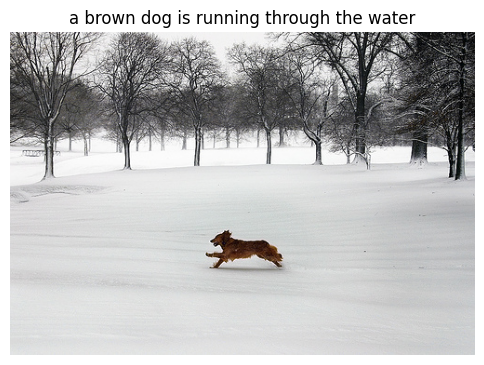


Image: 1009434119_febe49276a.jpg
Generated Caption: a dog runs through the grass


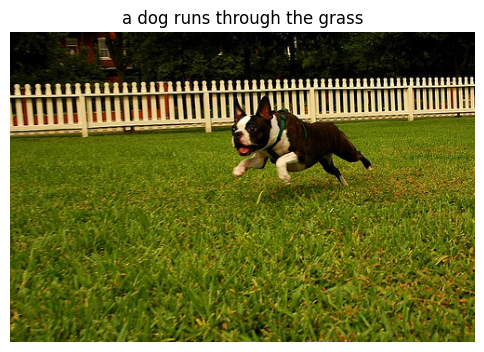

In [16]:
# Define the transform (same as training, minus random augmentations)
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# List of sample images (update these paths as needed)
test_images = [
    "96973080_783e375945.jpg",
    "1009434119_febe49276a.jpg"
]

def show_image_with_caption(img_path, caption):
    """
    Display an image with its generated caption.
    """
    plt.figure(figsize=(6, 5))
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    plt.show()

# Now loop over the test images, generate captions, and display
for img_path in test_images:
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
        continue
    
    # Generate the caption
    caption = generate_caption(
        encoder, decoder,
        img_path,
        inference_transform,
        idx2word,
        device,
        max_len=20
    )
    print(f"\nImage: {img_path}")
    print("Generated Caption:", caption)

    # Show the image inline with the caption
    show_image_with_caption(img_path, caption)
